In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


(15060, 41)

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5py",save_best_only=True)
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4200      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 30162 samples, validate on 15060 samples
Epoch 1/100
30162/30162 

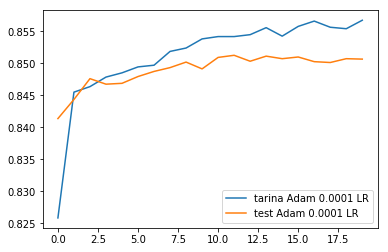

In [6]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [7]:
model.load_weights("wagi_best.h5py")
model.evaluate(X_test,y_test)

15060/15060 [==============================] - 0s 19us/step


[0.31751382611741424, 0.850265622138977]

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

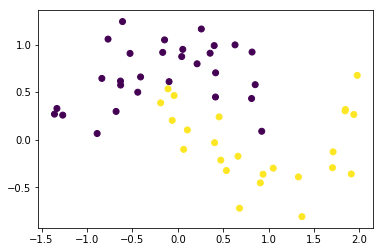

In [8]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [9]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.5094 - val_loss: 0.7198 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 621

53/53 [==============================] - 0s 696us/step - loss: 0.1939 - accuracy: 0.9057 - val_loss: 0.4427 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 866us/step - loss: 0.1936 - accuracy: 0.9057 - val_loss: 0.4440 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 753us/step - loss: 0.1895 - accuracy: 0.9245 - val_loss: 0.4534 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 922us/step - loss: 0.1854 - accuracy: 0.9245 - val_loss: 0.4741 - val_accuracy: 0.8085
Epoch 55/1000
53/53 [==============================] - 0s 903us/step - loss: 0.1852 - accuracy: 0.9245 - val_loss: 0.4864 - val_accuracy: 0.8085
Epoch 56/1000
53/53 [==============================] - 0s 922us/step - loss: 0.1865 - accuracy: 0.9434 - val_loss: 0.4819 - val_accuracy: 0.8085
Epoch 57/1000
53/53 [==============================] - 0s 809us/step - loss: 0.1830 - accuracy: 0.9434 - val_loss: 0.4628 - val_accuracy: 0.8298

53/53 [==============================] - 0s 640us/step - loss: 0.0697 - accuracy: 0.9811 - val_loss: 0.2210 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0663 - accuracy: 0.9811 - val_loss: 0.2225 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0637 - accuracy: 0.9811 - val_loss: 0.2210 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0631 - accuracy: 0.9811 - val_loss: 0.2154 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0589 - accuracy: 1.0000 - val_loss: 0.1996 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0600 - accuracy: 1.0000 - val_loss: 0.1882 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.1983 - val_accuracy: 0.9362
Epoch 164/1000
53/53 [==============================] - 0s 866us/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 0.9149
Epoch 165/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.9149
Epoch 166/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 0.9149
Epoch 167/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1861 - val_accuracy: 0.9149
Epoch 168/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.1856 - val_accuracy: 0.8936
Epoch 169/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 0.9362
Epoch 220/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1905 - val_accuracy: 0.9362
Epoch 221/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9149
Epoch 222/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1954 - val_accuracy: 0.9149
Epoch 223/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1961 - val_accuracy: 0.9149
Epoch 224/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9149
Epoch 225/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1965 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2047 - val_accuracy: 0.9149
Epoch 276/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2042 - val_accuracy: 0.9149
Epoch 277/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2048 - val_accuracy: 0.9149
Epoch 278/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2054 - val_accuracy: 0.9149
Epoch 279/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2063 - val_accuracy: 0.9149
Epoch 280/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2068 - val_accuracy: 0.9149
Epoch 281/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2079 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2222 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2225 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2237 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9149
Epoch 388/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2326 - val_accuracy: 0.9149
Epoch 389/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2333 - val_accuracy: 0.9149
Epoch 390/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2353 - val_accuracy: 0.9149
Epoch 391/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 392/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 393/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2350 - val_accuracy: 

53/53 [==============================] - 0s 602us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2494 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2517 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2533 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2520 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2512 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 9.9179e-04 - accuracy: 1.0000 - val_loss: 0.2607 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 583us/step - loss: 9.4471e-04 - accuracy: 1.0000 - val_loss: 0.2611 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 659us/step - loss: 9.3076e-04 - accuracy: 1.0000 - val_loss: 0.2621 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 602us/step - loss: 9.2143e-04 - accuracy: 1.0000 - val_loss: 0.2629 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 640us/step - loss: 9.1859e-04 - accuracy: 1.0000 - val_loss: 0.2635 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 659us/step - loss: 9.1592e-04 - accuracy: 1.0000 - val_loss: 0.2641 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 640us/step - loss: 9.3492e-04 - accuracy: 1.0000 - val_l

Epoch 554/1000
53/53 [==============================] - 0s 602us/step - loss: 7.6376e-04 - accuracy: 1.0000 - val_loss: 0.2749 - val_accuracy: 0.9149
Epoch 555/1000
53/53 [==============================] - 0s 696us/step - loss: 7.1429e-04 - accuracy: 1.0000 - val_loss: 0.2744 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 696us/step - loss: 7.3310e-04 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 677us/step - loss: 7.0248e-04 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 621us/step - loss: 7.0012e-04 - accuracy: 1.0000 - val_loss: 0.2742 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 640us/step - loss: 7.1599e-04 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.9149
Epoch 560/1000
53/53 [==============================] - 0s 640us/step - loss: 6.9192e-04 - accuracy:

53/53 [==============================] - 0s 583us/step - loss: 5.6294e-04 - accuracy: 1.0000 - val_loss: 0.2840 - val_accuracy: 0.9149
Epoch 609/1000
53/53 [==============================] - 0s 602us/step - loss: 5.5502e-04 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 621us/step - loss: 5.5616e-04 - accuracy: 1.0000 - val_loss: 0.2857 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 659us/step - loss: 5.6821e-04 - accuracy: 1.0000 - val_loss: 0.2861 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 658us/step - loss: 5.5148e-04 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 677us/step - loss: 5.4404e-04 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 677us/step - loss: 5.4691e-04 - accuracy: 1.0000 - val_l

53/53 [==============================] - 0s 621us/step - loss: 4.6961e-04 - accuracy: 1.0000 - val_loss: 0.2968 - val_accuracy: 0.9149
Epoch 663/1000
53/53 [==============================] - 0s 602us/step - loss: 4.4991e-04 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 664/1000
53/53 [==============================] - 0s 677us/step - loss: 4.4419e-04 - accuracy: 1.0000 - val_loss: 0.2935 - val_accuracy: 0.9149
Epoch 665/1000
53/53 [==============================] - 0s 696us/step - loss: 4.6583e-04 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 696us/step - loss: 4.4702e-04 - accuracy: 1.0000 - val_loss: 0.2927 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 715us/step - loss: 4.4404e-04 - accuracy: 1.0000 - val_loss: 0.2932 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 640us/step - loss: 4.3900e-04 - accuracy: 1.0000 - val_l

Epoch 717/1000
53/53 [==============================] - 0s 640us/step - loss: 3.7752e-04 - accuracy: 1.0000 - val_loss: 0.3054 - val_accuracy: 0.9149
Epoch 718/1000
53/53 [==============================] - 0s 640us/step - loss: 3.7578e-04 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy: 0.9149
Epoch 719/1000
53/53 [==============================] - 0s 621us/step - loss: 3.6379e-04 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy: 0.9149
Epoch 720/1000
53/53 [==============================] - 0s 621us/step - loss: 3.6882e-04 - accuracy: 1.0000 - val_loss: 0.3043 - val_accuracy: 0.9149
Epoch 721/1000
53/53 [==============================] - 0s 677us/step - loss: 3.7148e-04 - accuracy: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 696us/step - loss: 3.6953e-04 - accuracy: 1.0000 - val_loss: 0.3047 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 809us/step - loss: 3.5839e-04 - accuracy:

53/53 [==============================] - 0s 640us/step - loss: 3.0286e-04 - accuracy: 1.0000 - val_loss: 0.3112 - val_accuracy: 0.9149
Epoch 772/1000
53/53 [==============================] - 0s 697us/step - loss: 3.0116e-04 - accuracy: 1.0000 - val_loss: 0.3114 - val_accuracy: 0.9149
Epoch 773/1000
53/53 [==============================] - 0s 640us/step - loss: 3.0000e-04 - accuracy: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9149
Epoch 774/1000
53/53 [==============================] - 0s 659us/step - loss: 3.0032e-04 - accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.9149
Epoch 775/1000
53/53 [==============================] - 0s 1ms/step - loss: 2.9579e-04 - accuracy: 1.0000 - val_loss: 0.3141 - val_accuracy: 0.9149
Epoch 776/1000
53/53 [==============================] - 0s 677us/step - loss: 2.9383e-04 - accuracy: 1.0000 - val_loss: 0.3157 - val_accuracy: 0.9149
Epoch 777/1000
53/53 [==============================] - 0s 828us/step - loss: 3.1314e-04 - accuracy: 1.0000 - val_los

53/53 [==============================] - 0s 621us/step - loss: 2.5256e-04 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.9149
Epoch 826/1000
53/53 [==============================] - 0s 583us/step - loss: 2.5159e-04 - accuracy: 1.0000 - val_loss: 0.3222 - val_accuracy: 0.9149
Epoch 827/1000
53/53 [==============================] - 0s 584us/step - loss: 2.6031e-04 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9149
Epoch 828/1000
53/53 [==============================] - 0s 659us/step - loss: 2.5146e-04 - accuracy: 1.0000 - val_loss: 0.3239 - val_accuracy: 0.9149
Epoch 829/1000
53/53 [==============================] - 0s 640us/step - loss: 2.5449e-04 - accuracy: 1.0000 - val_loss: 0.3234 - val_accuracy: 0.9149
Epoch 830/1000
53/53 [==============================] - 0s 621us/step - loss: 2.4891e-04 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9149
Epoch 831/1000
53/53 [==============================] - 0s 640us/step - loss: 2.4820e-04 - accuracy: 1.0000 - val_l

Epoch 880/1000
53/53 [==============================] - 0s 621us/step - loss: 2.1280e-04 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9149
Epoch 881/1000
53/53 [==============================] - 0s 583us/step - loss: 2.1186e-04 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9149
Epoch 882/1000
53/53 [==============================] - 0s 659us/step - loss: 2.1535e-04 - accuracy: 1.0000 - val_loss: 0.3318 - val_accuracy: 0.9149
Epoch 883/1000
53/53 [==============================] - 0s 602us/step - loss: 2.1571e-04 - accuracy: 1.0000 - val_loss: 0.3327 - val_accuracy: 0.9149
Epoch 884/1000
53/53 [==============================] - 0s 621us/step - loss: 2.1303e-04 - accuracy: 1.0000 - val_loss: 0.3327 - val_accuracy: 0.9149
Epoch 885/1000
53/53 [==============================] - 0s 621us/step - loss: 2.1005e-04 - accuracy: 1.0000 - val_loss: 0.3322 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 659us/step - loss: 2.0809e-04 - accuracy:

53/53 [==============================] - 0s 659us/step - loss: 1.8227e-04 - accuracy: 1.0000 - val_loss: 0.3391 - val_accuracy: 0.9149
Epoch 935/1000
53/53 [==============================] - 0s 640us/step - loss: 1.8173e-04 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9149
Epoch 936/1000
53/53 [==============================] - 0s 602us/step - loss: 1.8136e-04 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9149
Epoch 937/1000
53/53 [==============================] - 0s 659us/step - loss: 1.8381e-04 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9149
Epoch 938/1000
53/53 [==============================] - 0s 678us/step - loss: 1.8024e-04 - accuracy: 1.0000 - val_loss: 0.3397 - val_accuracy: 0.9149
Epoch 939/1000
53/53 [==============================] - 0s 659us/step - loss: 1.8415e-04 - accuracy: 1.0000 - val_loss: 0.3407 - val_accuracy: 0.9149
Epoch 940/1000
53/53 [==============================] - 0s 659us/step - loss: 1.7937e-04 - accuracy: 1.0000 - val_l

Epoch 989/1000
53/53 [==============================] - 0s 659us/step - loss: 1.5794e-04 - accuracy: 1.0000 - val_loss: 0.3461 - val_accuracy: 0.9149
Epoch 990/1000
53/53 [==============================] - 0s 621us/step - loss: 1.5806e-04 - accuracy: 1.0000 - val_loss: 0.3460 - val_accuracy: 0.9149
Epoch 991/1000
53/53 [==============================] - 0s 640us/step - loss: 1.5996e-04 - accuracy: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9149
Epoch 992/1000
53/53 [==============================] - 0s 621us/step - loss: 1.5982e-04 - accuracy: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9149
Epoch 993/1000
53/53 [==============================] - 0s 621us/step - loss: 1.5678e-04 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.9149
Epoch 994/1000
53/53 [==============================] - 0s 659us/step - loss: 1.5927e-04 - accuracy: 1.0000 - val_loss: 0.3483 - val_accuracy: 0.9149
Epoch 995/1000
53/53 [==============================] - 0s 621us/step - loss: 1.5477e-04 - accuracy:

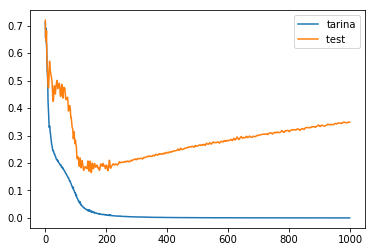

In [10]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


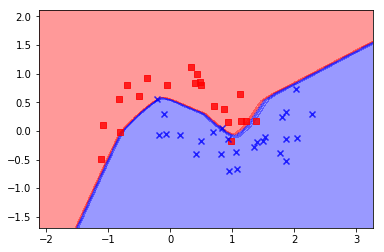

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [13]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1, early_stopping])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.7406 - accuracy: 0.4528 - val_loss: 0.6788 - val_accuracy: 0.6170
Epoch 2/1000
53/53 [==============================] - 0s 546

53/53 [==============================] - 0s 565us/step - loss: 0.1894 - accuracy: 0.9245 - val_loss: 0.4412 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 583us/step - loss: 0.1909 - accuracy: 0.9057 - val_loss: 0.4485 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 884us/step - loss: 0.1848 - accuracy: 0.9245 - val_loss: 0.4799 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 753us/step - loss: 0.1851 - accuracy: 0.9434 - val_loss: 0.4954 - val_accuracy: 0.8085
Epoch 55/1000
53/53 [==============================] - 0s 847us/step - loss: 0.1847 - accuracy: 0.9434 - val_loss: 0.4841 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.1802 - accuracy: 0.9245 - val_loss: 0.4577 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 884us/step - loss: 0.1787 - accuracy: 0.9245 - val_loss: 0.4404 - val_accuracy: 0.8298
E

53/53 [==============================] - 0s 659us/step - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.1880 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 0.1892 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.2026 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0556 - accuracy: 1.0000 - val_loss: 0.2099 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0538 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0513 - accuracy: 1.0000 - val_loss: 0.2005 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 678us/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.1763 - val_accuracy: 0.9149
Epoch 164/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 0.9149
Epoch 165/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1787 - val_accuracy: 0.8936
Epoch 166/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.1887 - val_accuracy: 0.9149
Epoch 167/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.1969 - val_accuracy: 0.9149
Epoch 168/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9362
Epoch 169/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1919 - val_accuracy: 

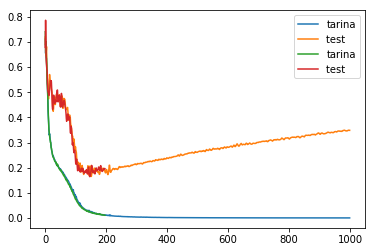

In [14]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

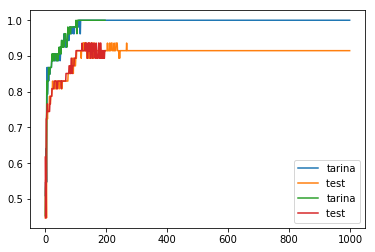

In [15]:
plt.plot(history_Adam.history['accuracy'], label = "tarina")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.plot(history_Adam_1.history['accuracy'], label = "tarina")
plt.plot(history_Adam_1.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


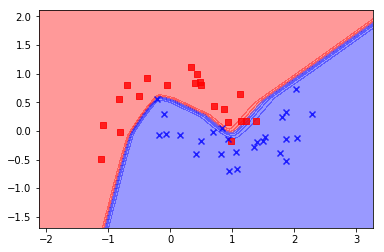

In [16]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()